
# Week 2 — Baseline Prediction Models & Evaluation

In this notebook, you will build **baseline prediction models** for financial
returns and evaluate them using **strictly forward-looking (time-series)
validation**.

This week focuses on **evaluation discipline**, not on maximizing performance.


## 1. Imports

In [38]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

plt.style.use("seaborn-v0_8")



## 2. Load data from Week 1

- Reuse the data you created in Week 1.
- You can use one stock of your choice (you can repeat it for multiple stocks if you want and plot them separately)
- Take a long term horizon data set (5-10 years)


In [39]:
asset = ["AAPL", "MSFT","GOOG"]      
#taking long term data
start = "2015-01-01"
end   = "2024-01-01"

data = yf.download(asset, start=start, end=end, auto_adjust=False)

prices = data["Adj Close"].ffill().bfill()

log_returns = np.log(prices).diff().dropna()


[*********************100%***********************]  3 of 3 completed



## 3. Feature construction

Required features:
- $r_t$
- $r_{t-1}$
- 20-day rolling mean
- 20-day rolling volatility
- 5-day momentum


In [40]:
# feat denoted features here 

feat = pd.DataFrame(index=log_returns.index)

feat["return_today"] = log_returns

feat["return_yesterday"] = log_returns.shift(1)

feat["rolling_mean20d"] =log_returns.rolling(20).mean()

feat["rolling_vol20d"] =log_returns.rolling(20).std()

feat["momentum_5d"]= log_returns.rolling(5).sum()

# To remove NaNs
feat = feat.dropna()

feat.head()


ValueError: Cannot set a DataFrame with multiple columns to the single column return_today


## 4. Naive baselines


In [41]:

# TODO: zero predictor
zero_predictor= pd.Series(0.0,index=feat.index,name="Zero_ret_predic")
zero_predictor.head()


Date
2015-01-05    0.0
2015-01-06    0.0
2015-01-07    0.0
2015-01-08    0.0
2015-01-09    0.0
Name: Zero_ret_predic, dtype: float64

In [42]:
# TODO: rolling mean predictor
roll_mean_pred= feat["rolling_mean20d"].copy()
roll_mean_pred.name = "roll_mean_pred"

roll_mean_pred.head()



KeyError: 'rolling_mean20d'

In [22]:
#to use in task 5 and forward

# we need to set out target as next day return
y= log_returns.shift(-1)
y = y.loc[feat.index]
# needed to add this else it gives NaN error at start
#_____________________
y=y.dropna()
feat = feat.loc[y.index]
zero_predictor = zero_predictor.loc[y.index]
roll_mean_pred = roll_mean_pred.loc[y.index]
#______________________

# using walk forward series
time_ser =TimeSeriesSplit(n_splits=5)

mse_zero = []
mse_roll = []
# Calulating MSE for zero and rolling predictor

for training_idx, testing_idx in time_ser.split(feat):
    y_test = y.iloc[testing_idx]
    # for zero predictor
    zero_pred_test = zero_predictor.iloc[testing_idx]
    mse_zero.append(mean_squared_error(y_test, zero_pred_test))
    # for Rolling mean predictor
    roll_pred_test = roll_mean_pred.iloc[testing_idx]
    mse_roll.append(mean_squared_error(y_test, roll_pred_test))


Below , We can see Zero return predictor perform strong than rolling mean predictor. Rolling mean predictor have short term persistence.

In [23]:
# To compare these baseline predictors
print("Zero predictor MSE:", np.mean(mse_zero))
print("Rolling mean predictor MSE:", np.mean(mse_roll))



Zero predictor MSE: 0.00034657626893842017
Rolling mean predictor MSE: 0.00036042981804028276



## 5. Linear models (OLS & Ridge)
Suggested that you review basic linear regression theory as well (resources given in README).

In [24]:

# use LinearRegression from sklearn
mse_ols = []

for training_idx, testing_idx in time_ser.split(feat):
    # Split features
    X_train = feat.iloc[training_idx]
    X_test  = feat.iloc[testing_idx]
    
    # target split
    y_train = y.iloc[training_idx]
    y_test  = y.iloc[testing_idx]
    
    # OLS model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predicting
    y_pred = model.predict(X_test)
    
    # Evaluation 
    mse_ols.append(mean_squared_error(y_test, y_pred))

# to analyse results
print("OLS predictor MSE:", np.mean(mse_ols))

OLS predictor MSE: 0.00034983177879872803


The OLS model did not outperform zero return baseline model . It was evaluated using walk forward time and MSE method. Data is noisy , we get limited prediction from this model.

Zero predictor MSE: 0.0003466
OLS predictor MSE:  0.0003498


## 6. Tree-based model (Random Forest) (optional)


Random Forest was not implemented as the focus of this work was on naive baselines and correct walk-forward evaluation for linear models, which
are the main learning objectives of Week 2..... did not understand it well too .

In [25]:

rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=5,
    min_samples_leaf=50,
    random_state=42
)



## 7. Walk-forward evaluation

- Scikit reference for [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html).

Walk-forward (time-series) evaluation is implemented above in task 4 and 5 as per use , using
TimeSeriesSplit. All models were trained on past data and evaluated
on future data only, no look-ahead bias.


## 8. Prediction accuracy


I used MSE for evaluation above. Well simply RMSE is square root of MSE it won't change results of model comparison.

In [26]:

# TODO: compute RMSE for all models and compare them
res = pd.DataFrame({"Model": ["Zero Predictor", "Rolling Mean","OLS"], "MSE": [np.mean(mse_zero),np.mean(mse_roll),np.mean(mse_ols)] })
res["RMSE"] = np.sqrt(res["MSE"])
res

,Model,MSE,RMSE
0,Zero Predictor,0.000347,0.018617
1,Rolling Mean,0.000360,0.018985
2,OLS,0.000350,0.018704


All models achieve very similar MSE values.
The zero-return predictor performs comparably to rolling mean and OLS models.

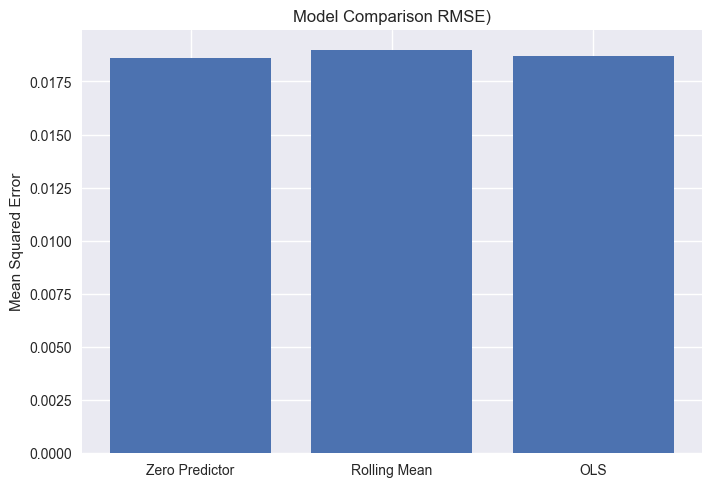

In [27]:
# TODO: plot rolling RMSE vs time for all models to compare their performance across different time periods/regimes
plt.bar(res["Model"], res["RMSE"])
plt.title("Model Comparison RMSE)")
plt.ylabel("Mean Squared Error")
plt.show()

In [54]:
# Bonus: compute volatility scaled/normalized prediction error: sqrt( ((y_true - y_pred)**2) / (vol_t**2) ) - and compare across models


## 9. Bonus: Looking at a toy strategy based on predictions
Define a simple "all-in" strategy where you go all long (+1) when you predict the stock to be going up, and all short (-1) when you predict the stock to be going down
$$
\text{position}_t = \text{sign}(y_\text{pred})
$$
Then, your returns for the $t$-th day (assuming daily returns) will be $(\text{position}_t \times y_\text{true})$ (note $y_\text{true} = r_t$).

Note that this is extremely simplistic and ignore any predictions related magnitude of expected returns, or expected volatility data etc. It is used only as a demonstration of what a prediction-based strategy may look like.

**Plot your returns using this strategy based on all the models above and compare them!**

In [28]:
y=y.squeeze()
# TODO: compute the positions for each model and daily returns
pos_zero = np.sign(zero_predictor).shift(1)
pos_roll= np.sign(roll_mean_pred).shift(1)

# evaluating returns (pos x y)
return_zero = (pos_zero*y).dropna()
return_roll = (pos_roll*y).dropna()
cumulative_zero = (1 + return_zero).cumprod()
cumulative_roll = (1 + return_roll).cumprod()


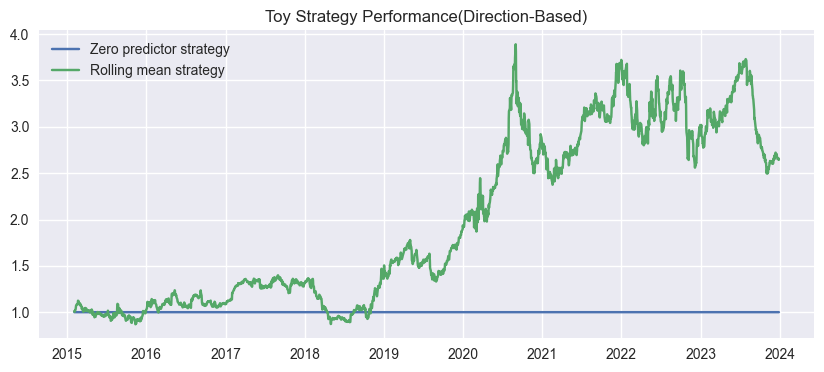

In [29]:
# TODO: plot your returns
plt.figure(figsize=(10, 4))
plt.plot(cumulative_zero, label="Zero predictor strategy")
plt.plot(cumulative_roll, label="Rolling mean strategy")
plt.legend()
plt.title("Toy Strategy Performance(Direction-Based)")
plt.show()

After correcting for look-ahead bias by shifting positions forward by one day,
the rolling mean strategy still shows positive cumulative returns over the
sample period.As the plot is right as , for zero prediction return = 0 , cumulative return in net always remains equal to 1 unit.

In [32]:
#for week 4
returns_df = log_returns.dropna()
mu_hat = returns_df.mean().values
Sigma_hat = np.cov(returns_df.values, rowvar=False)
tickers = returns_df.columns.tolist()

np.savez(
    "predictions.npz",
    mu_hat=mu_hat,
    Sigma_hat=Sigma_hat,
    tickers=tickers
)
print("Saved predictions.npz")
print("mu_hat shape:", mu_hat.shape)
print("Sigma_hat shape:", Sigma_hat.shape)

Saved predictions.npz
mu_hat shape: (1,)
Sigma_hat shape: ()



## 10. Discussion questions

1. Why do we need naive baselines?
2. How does the evaluation strategy here (walk-forward evaluation) differ from the random training-test dataset splits used in convention ML?
3. *(Addon)* And, why does random splitting technique fail here?
4. Interpret the RMSE values and rolling RMSE plot results very briefly.
5. *(Addon)* Are there periods where model performance degrades noticeably? What might this indicate?
6. Why might Random Forest overfit?
7. *(Bonus)* Two models have similar RMSE, but one makes larger errors primarily during high-volatility periods. Why might this model be *less dangerous* in a portfolio context?

1. Naive baselines provide a reference point to evaluate whether the model is economically useful and it gives some meaningful signal rather than noise.
2. Random split test can give pverly optimistic results and look ahead bias .Walk forward proceeds according to order of data , training on past data.
3. it will take future data for prediction , which is past reality and gives wrong results.
4. Well RMSe value were close for all models, showing predictions give limited knowledge and are noisy .
5. Models we used above can perform bad when there is high volatility in data .It indicates stable period going on in market doesn't signify if future continues the same at all there's much noise.
7. It is because, large errors during volatile periods are expected as markets are noisy.
These mistakes are often less concerning since exposure is usually reduced and porfolio risk can be managed .
